本章では以下の内容を取り上げる。
- データセットの探索と可視化
- 線形回帰モデルを実装するための各種アプローチの考察
- 外れ値に対して頑健なモデルのトレーニング
- 回帰モデルの評価と一般的な問題の診断
- 回帰モデルの非線形データでの学習

## 10.2 Housingデータセットの探索
### 10.2.1 Housingデータセットをデータフレームに読み込み

In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                'python-machine-learning-book-2nd-edition'
                '/master/code/ch10/housing.data.txt',header=None, sep='\s+')
df.columns = ['CRIM', 'EN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
             'TAX', 'PTRATTO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,EN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATTO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
# 変数のペアの関係をプロット：dfはDataFrameオブジェクト、sizeは1面のインチサイズ
sns.pairplot(df[cols], size=2.5)
plt.tight_layout()
plt.show()

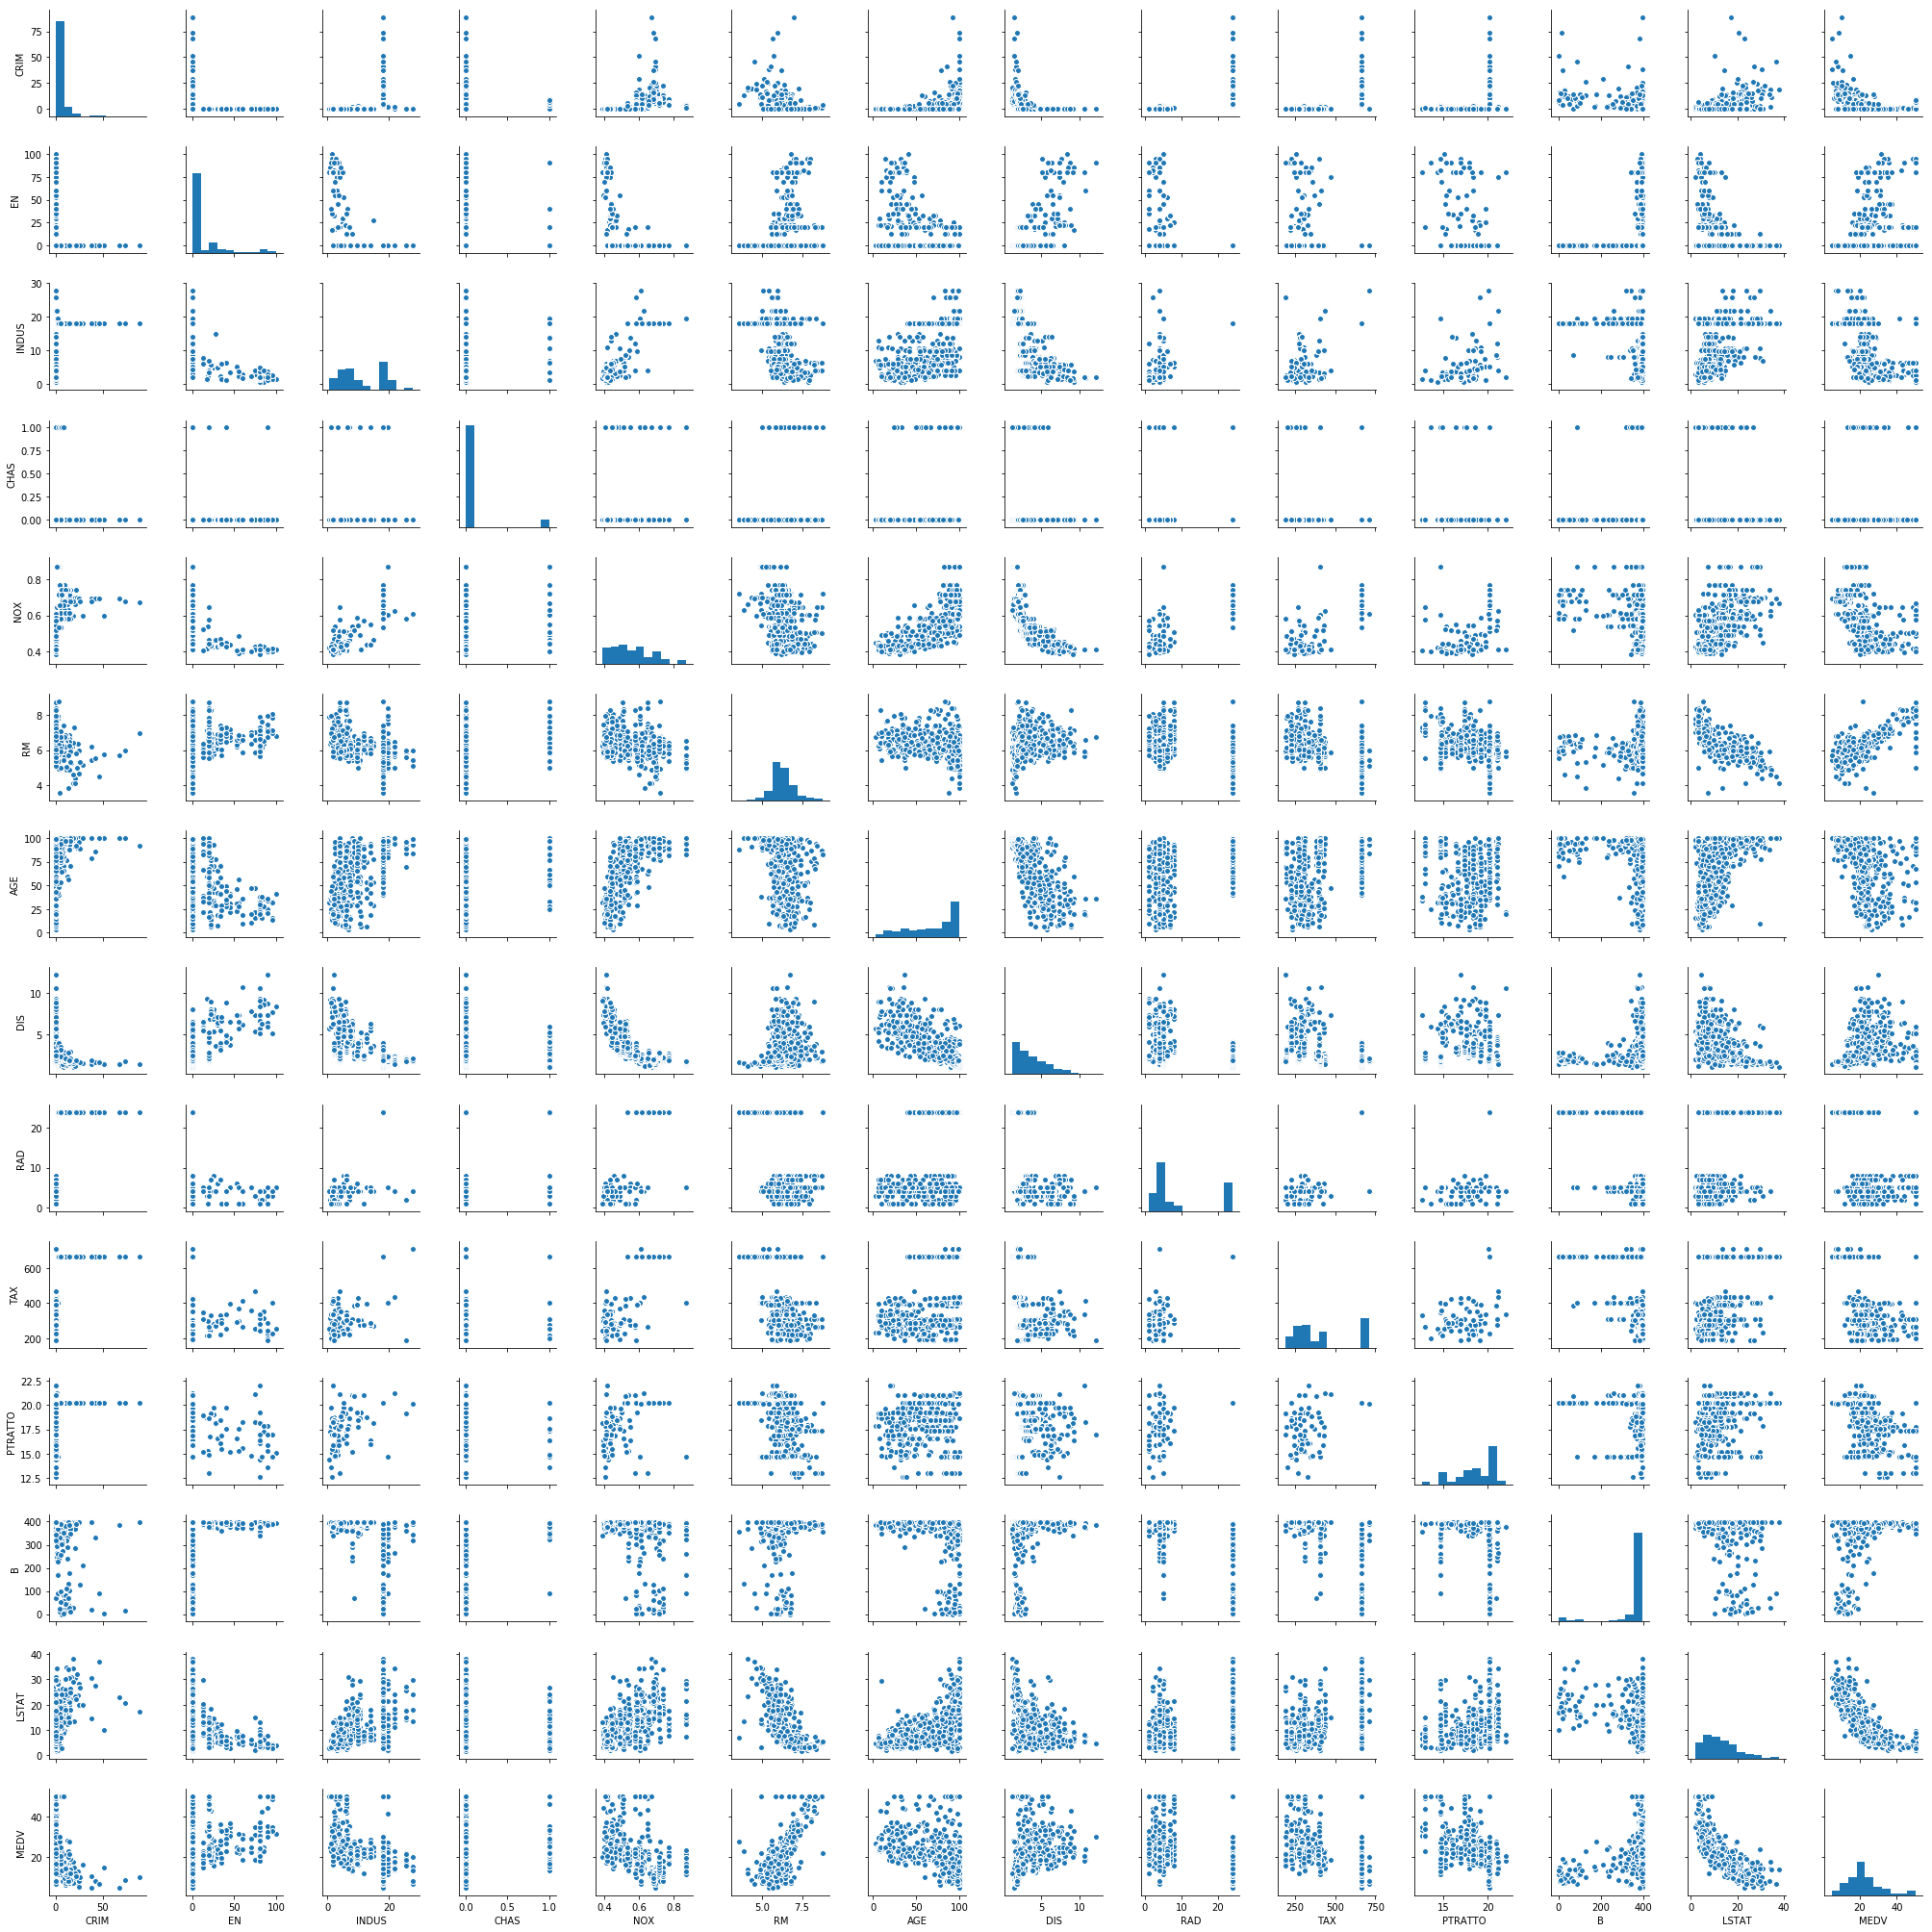

In [3]:
sns.pairplot(df, size=2.0)
plt.tight_layout()
plt.show()

## 10.2.3 相関行列を使って調べる

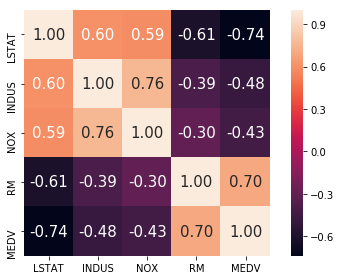

In [4]:
import numpy as np
cm = np.corrcoef(df[cols].values.T) # ピアソンの積率相関係数を計算

'''
#　第1引数の相関係数を元にヒートマップを作成
#　カラーバーの表示
#　データ値の表示
#　各短形の正方形化（縦と横のサイズを一致させる）
#　数値の表示形式
#　データ値のサイズの設定
#　行のメモリラベル名
#　列のメモリラベル名
'''
hm = sns.heatmap(cm,
                cbar = True,               
                annot = True,
                square = True,
                fmt = '.2f',
                annot_kws = {'size': 15},
                yticklabels = cols,
                xticklabels = cols)
plt.tight_layout()
plt.show()

MEDV(住宅価格値の中央値）ともっとも相関しているRM（部屋数）が説明変数に適していると思われる。

## 10.3 最小2乗線形回帰モデルの実装
### 10.3.1 勾配降下法使って回帰パラメータの回帰を解く

In [5]:
class LinearRegressionGD(object):
    # 初期化を実行する__init__
    def __init__(self, eta =0.001, n_iter = 20):
        self.eta = eta
        self.n_iter = n_iter
        
    # トレーニングを実行する
    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        print(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors ** 2).sum()/2.0
            self.cost_.append(cost)
        return self
    
    #　総入力を計算する
    def net_input(self, X):
        return np.dot(X,self.w_[1:]) + self.w_[0]
    
    #　予測値を計算する
    def predict(self, X):
        return self.net_input(X)

In [6]:
X = df[['RM']].values
y = df['MEDV'].values

from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()

X_std = sc_x.fit_transform(X)

# newaxisで配列に新しい次元を追加し、StandardScalerで変数が返されたあとにflattenで1次元に戻している。
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
print(y.shape)
print(y_std.shape)

lr = LinearRegressionGD()
lr.fit(X_std, y_std)

(506,)
(506,)
1


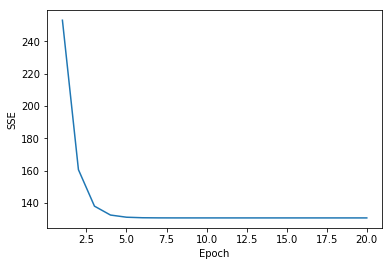

In [7]:
# エポック数とコストの関係を表す折れ線グラフのプロット
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

In [8]:
def lin_replot(X, y, model):
    plt.scatter(X, y, c = 'steelblue', edgecolor = 'White', s = 70)
    plt.plot(X, model.predict(X), color = 'black', lw=2)
    return

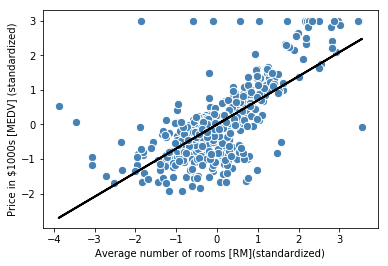

In [9]:
lin_replot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM](standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')
plt.show()

In [10]:
num_rooms_std = sc_x.transform([[5.0]])
price_std = lr.predict(num_rooms_std)
print("Price in $1000s: %.3f" % sc_y.inverse_transform(price_std))

Price in $1000s: 10.840


標準化された場合は切片は常に0になる。

In [11]:
print('Slope :%.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope :0.695
Intercept: -0.000


### 10.3.2 scikit-learnを使って回帰モデルの係数を推定する

In [12]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('Slope :%.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope :9.102
Intercept: -34.671


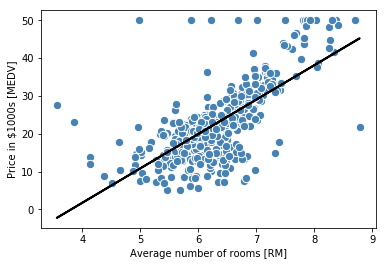

In [13]:
lin_replot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

## 10.4 RANSACを使ったロバスト回帰モデルの学習
このアルゴリズムは「正常値」を学習させる。（外れ値でないもの）
RANSACアルゴリズムの反復処理の内容は以下の通りである。
- 正常値としてランダムな数のサンプルを選択し、モデルを学習させる。
- 学習済みのモデルに対して、その他すべてのデータ点を評価し、ユーザー指定の形容範囲となるデータ点を正常値に追加する。
- すべての正常値を使ってモデルを再び学習させる。
- 正常値に対する学習ずみのモデルの誤差を推定する。
- モデルの性能がユーザーの指定のしきい値の条件を満たしている場合、またはイテレーションが既定の回数に達した場合はアルゴリズムを終了する。そうでなければ1に戻る。

In [14]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(),
                        max_trials = 100,
                        min_samples = 50,
                        loss = 'absolute_loss',
                        residual_threshold = 5.0,
                        random_state = 0)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=50, random_state=0,
        residual_metric=None, residual_threshold=5.0, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

(7,)


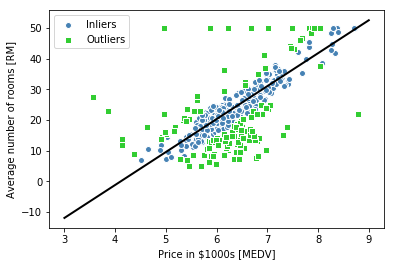

In [15]:
# 正常値を表す真偽値を取得
inlier_mask = ransac.inlier_mask_

# 外れ値を表す真偽値を取得
outlier_mask = np.logical_not(inlier_mask)

# 3から9までの整数値を取得
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
print(line_y_ransac.shape)

# 正常値をプロット
plt.scatter(X[inlier_mask], y[inlier_mask],
            c = 'steelblue',edgecolor = 'white', marker = 'o',label = 'Inliers')

# 外れ値をプロット
plt.scatter(X[outlier_mask], y[outlier_mask],
           c = 'limegreen', edgecolor = 'white', marker = 's', label = 'Outliers')

# 予測値をプロット
plt.plot(line_X, line_y_ransac, color ='black', lw=2)
plt.ylabel('Average number of rooms [RM]')
plt.xlabel('Price in $1000s [MEDV]')
plt.legend(loc='best')
plt.show()

In [16]:
print('Slope :%.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope :10.735
Intercept: -44.089


## 10.5 線形回帰モデルの性能評価

In [17]:
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.3, random_state = 0)

slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

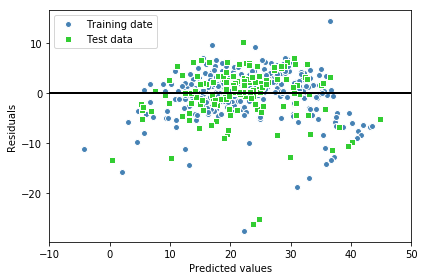

In [18]:
plt.scatter(y_train_pred, y_train_pred - y_train,
           c = 'steelblue', marker ='o', edgecolor = 'white', label = 'Training date')
plt.scatter(y_test_pred, y_test_pred - y_test,
           c = 'limegreen', marker ='s', edgecolor = 'white', label = 'Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc ='best')
plt.hlines (y = 0, xmin =-10, xmax =50, color='black', lw=2)
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error

print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train,y_train_pred),
                                      mean_squared_error(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196


In [20]:
# R^2（決定係数）のスコアを出力 R^2=1に近づくほど精度が高い
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),
                                      r2_score(y_test, y_test_pred)))

R^2 train: 0.765, test: 0.673


## 10.6 回帰に正則化手法を使用する
過学習を抑制するためにパラメータの重みの更新にペナルティを科す手法が正則化である。
代表的な正則化は以下の3つである。
- リッジ回帰 (Ridge regression)
- LASSO (Least Absolute Shrinkage and Selection Operation)
- Elastic Net 

In [21]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha = 1.0)

In [22]:
from sklearn.linear_model import  Lasso
lasso = Lasso(alpha = 1.0)

In [23]:
from sklearn.linear_model import ElasticNet
elanet = ElasticNet(alpha = 1.0, l1_ratio = 0.5)

## 10.7 多項式回帰：線形回帰モデルから曲線を見出す
### 10.7.1 scikit-learn を使って多項式の項を追加する

1. 多項式の2次の項を追加する

In [30]:
from sklearn.preprocessing import PolynomialFeatures
X = np.array([258.0, 270.0, 320.0, 342.0, 368.0, 396.0, 446.0, 480.0,
              586.0])[:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 298.6, 314.2, 360.8, 368.0, 391.2,
             390.8])

lr = LinearRegression()
pr = LinearRegression()

# 2項の多項式特徴量のクラスをインスタンス化する
quadratic = PolynomialFeatures(degree =2)
# データに適合させ、データを変換
X_quad = quadratic.fit_transform(X)

2. 比較を簡単にするために、単回帰モデルを学習する

In [37]:
lr.fit(X, y)
# np.newaxisで列ベクトルにする
X_fit = np.arange(250,600, 10)[:, np.newaxis]
print(X_fit.T)
y_lin_fit = lr.predict(X_fit)

[[250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420
  430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590]]


3. 多項式回路のために、変換された特徴量で重回帰モデルを学習させる。

In [32]:
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

4. 結果をプロットする

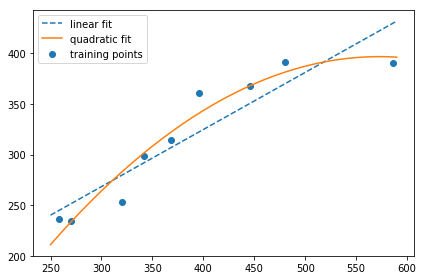

In [33]:
plt.scatter(X, y, label = 'training points')
plt.plot(X_fit, y_lin_fit, label = 'linear fit', linestyle = '--')
plt.plot(X_fit, y_quad_fit, label = 'quadratic fit')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [35]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

print('Training MSE linear: %.3f, quadratic: %.3f' %
     (mean_squared_error(y, y_lin_pred), mean_squared_error(y, y_quad_pred)))

print('Training R^2 linear: %.3f, quadratic: %.3f' %
     (r2_score(y, y_lin_pred), r2_score(y, y_quad_pred)))

Training MSE linear: 545.427, quadratic: 195.355
Training R^2 linear: 0.852, quadratic: 0.947


### 10.7.2 Housingデータセットで非線形をモデル化する
２次(quadratic)と３次(cubic)の多項式を使ってMEDV(住宅価格の中央値）とLSTAT（低所得の割合）の関係をモデル化し線形回帰モデルと多項式回帰モデルの結果を比較する。

In [ ]:
X = df[['LSTAT']].values
y = df['MEDV'].values
regr = LinearRegression()

# 2次と3次の特徴量を作成
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# 特徴量の学習
X_fit = np.arange(X.min(), X.max(),1)[:, np.newaxis]
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, y_lin_fit)